In [ ]:
# CELL 1: DOWNLOAD THE DATA

import kagglehub

print("Downloading dataset from Kaggle Hub...")
data_root_path = kagglehub.dataset_download("mozillaorg/common-voice")
print(f"✅ Dataset is ready and the path is stored in 'data_root_path': {data_root_path}")

Download already complete (12931472693 bytes).
Extracting files...
✅ Dataset is ready and the path is stored in 'data_root_path': /root/.cache/kagglehub/datasets/mozillaorg/common-voice/versions/2


In [ ]:
# --- Step 1: INSTALLATIONS, IMPORTS, and DOWNLOAD ---

# Install required libraries
!pip install kagglehub tqdm soundfile -q

# Import foundational libraries
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from tqdm import tqdm
import librosa

warnings.filterwarnings('ignore')
print("Libraries imported.")

# Download the dataset using kagglehub
print("\nDownloading dataset from Kaggle Hub...")
data_root_path = kagglehub.dataset_download("mozillaorg/common-voice")
print(f"✅ Dataset is ready at: {data_root_path}")

Libraries imported.

✅ Dataset is ready at: /root/.cache/kagglehub/datasets/mozillaorg/common-voice/versions/2


✅ Successfully loaded and combined metadata. Total rows: 199771

Building the full file paths for each audio clip...
✅ Full paths created successfully.

Generating data exploration plots...


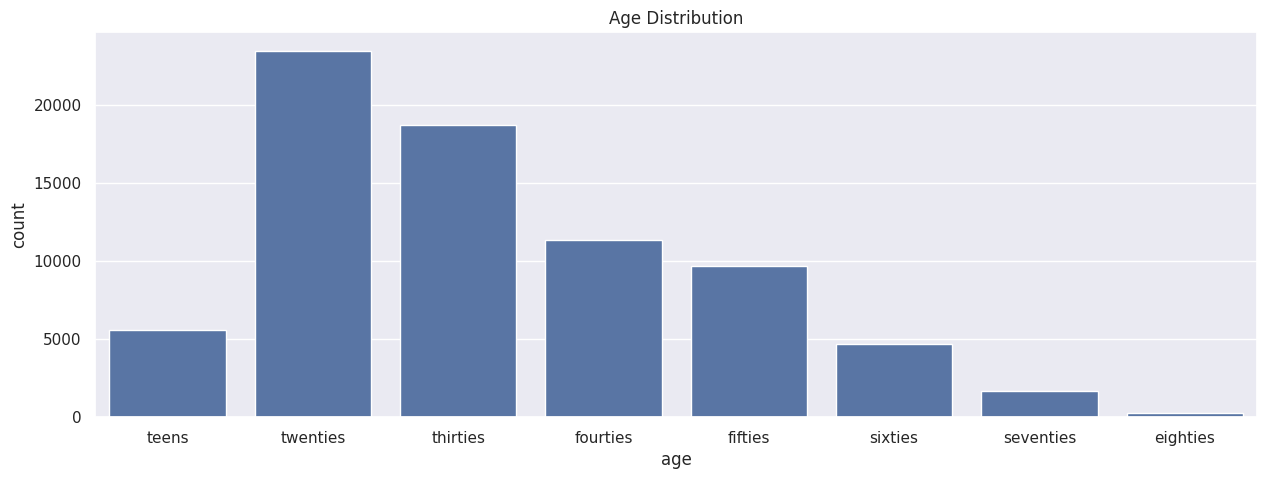

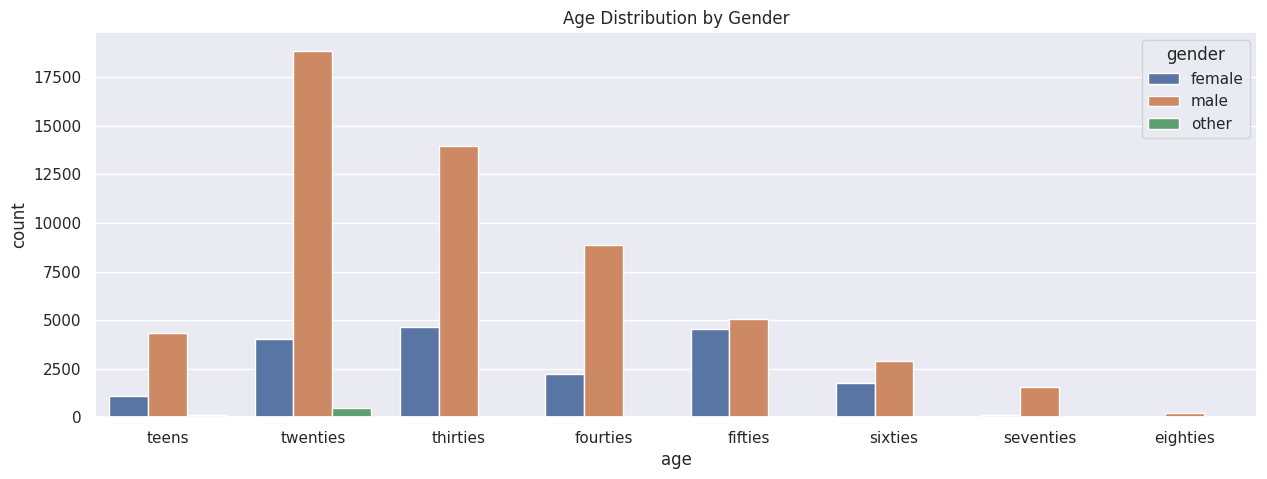

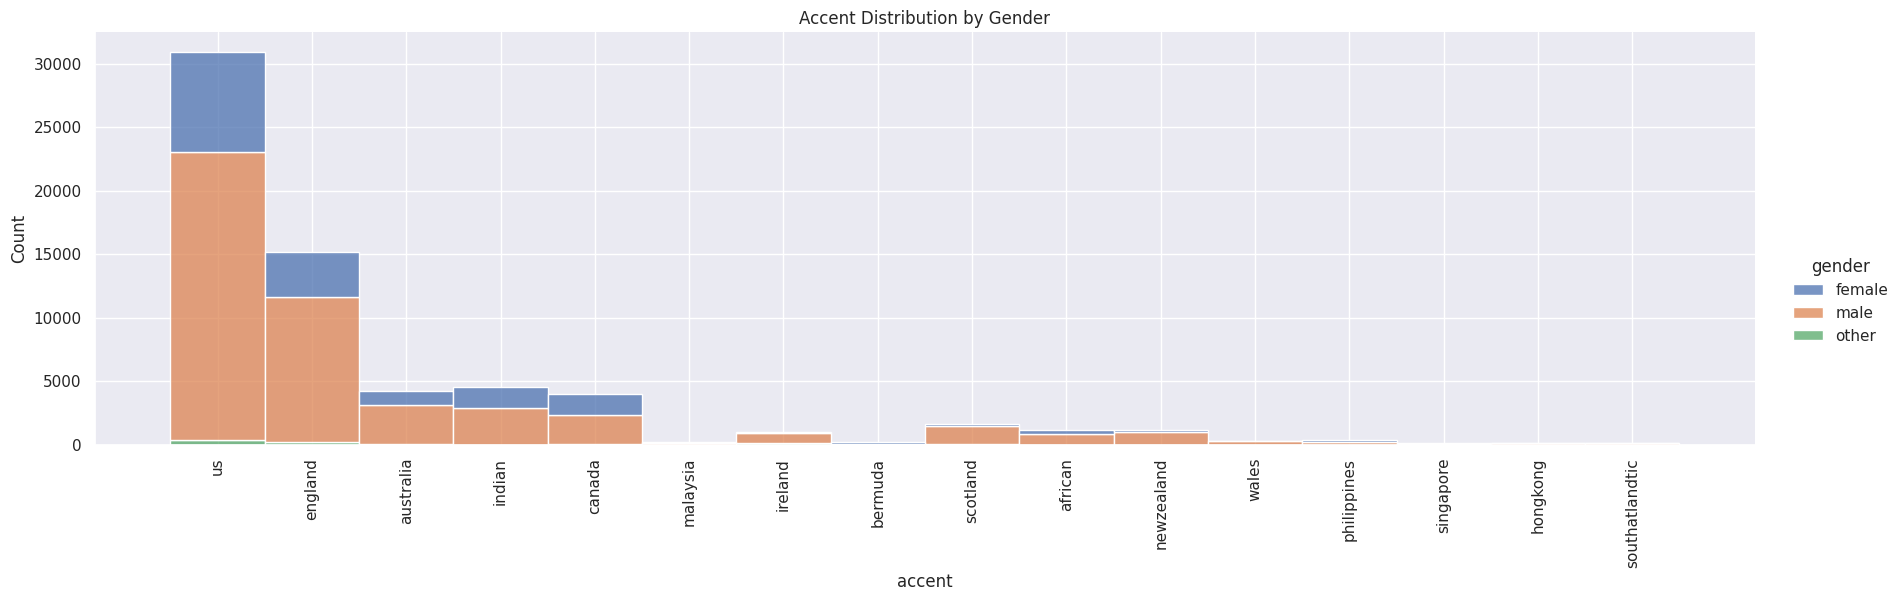


Filtering and cleaning data for model training...
✅ Data filtering and cleaning complete.
Final number of samples for feature extraction: 75001


,full_path,filename,age,gender
0,/root/.cache/kagglehub/datasets/mozillaorg/com...,cv-valid-train/sample-000005.mp3,twenties,0.0
1,/root/.cache/kagglehub/datasets/mozillaorg/com...,cv-valid-train/sample-000008.mp3,seventies,1.0
2,/root/.cache/kagglehub/datasets/mozillaorg/com...,cv-valid-train/sample-000013.mp3,thirties,0.0
3,/root/.cache/kagglehub/datasets/mozillaorg/com...,cv-valid-train/sample-000014.mp3,sixties,1.0
4,/root/.cache/kagglehub/datasets/mozillaorg/com...,cv-valid-train/sample-000019.mp3,fifties,1.0


In [ ]:
# --- Step 2: LOAD, BUILD PATHS, EXPLORE, AND PREPARE DATA ---

# Load and combine the training and test metadata
train_csv_path = os.path.join(data_root_path, 'cv-valid-train.csv')
test_csv_path = os.path.join(data_root_path, 'cv-valid-test.csv')
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)
df = pd.concat([df_train, df_test], ignore_index=True)
print(f"✅ Successfully loaded and combined metadata. Total rows: {len(df)}")

# --- CRITICAL: Build the correct, absolute path to each audio file ---
def build_the_one_true_path(row):
    just_the_filename = os.path.basename(row['filename'])
    if 'train' in row['filename']: parent_folder = 'cv-valid-train'
    elif 'test' in row['filename']: parent_folder = 'cv-valid-test'
    elif 'dev' in row['filename']: parent_folder = 'cv-valid-dev'
    else: return None
    return os.path.join(data_root_path, parent_folder, parent_folder, just_the_filename)

print("\nBuilding the full file paths for each audio clip...")
df['full_path'] = df.apply(build_the_one_true_path, axis=1)
df.dropna(subset=['full_path'], inplace=True)
print("✅ Full paths created successfully.")


# --- Step 3: EXPLORE THE DATA (NOW DONE ON THE FULL DATAFRAME) ---
print("\nGenerating data exploration plots...")

# Plot Age Distribution
sns.set(rc={'figure.figsize':(15, 5)})
sns.countplot(x="age",
              data=df[df['age'].notna()],
              order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])
plt.title("Age Distribution")
plt.show()

# Plot Age Distribution by Gender
sns.countplot(x="age",
              hue='gender',
              data=df[df['age'].notna()],
              order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])
plt.title("Age Distribution by Gender")
plt.show()

# Plot Accent Distribution by Gender
sns.displot(x="accent",
            data=df[df['accent'].notna()],
            hue='gender',
            multiple='stack',
            height=5, aspect=18/5)
plt.title("Accent Distribution by Gender")
plt.xticks(rotation=90)
plt.show()


# --- Step 4: FILTER AND CLEAN THE DATA FOR THE MODEL ---
print("\nFiltering and cleaning data for model training...")

# Select only the columns we need for the model
df_clean = df[['full_path', 'filename', 'age', 'gender']]

# To clean the data we remove the samples with NaN attribute values.
data = df_clean[df_clean['age'].notna() & df_clean['gender'].notna()]
data.reset_index(inplace=True, drop=True)

# Convert gender labels to numeric values (male:1, female:0)
cleanup_nums = {"gender": {"male": 1, "female": 0, "other": 0.5}}
data = data.replace(cleanup_nums)

print("✅ Data filtering and cleaning complete.")
print(f"Final number of samples for feature extraction: {len(data)}")
display(data.head())

In [ ]:
# --- Step 5: EXTRACT FEATURES FROM AUDIO FILES ---

# Your feature extraction function (no changes needed to the function itself)
def feature_extraction(audio_path, gender, sampling_rate=48000):
    try:
        features = list()
        audio, _ = librosa.load(audio_path, sr=sampling_rate, duration=5) # Added duration limit

        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))

        features.append(gender)
        features.append(spectral_centroid)
        features.append(spectral_bandwidth)
        features.append(spectral_rolloff)

        mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
        for el in mfcc:
            features.append(np.mean(el))

        return features
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# --- Process a subset of the data ---
# Use the 'data' DataFrame we created in the cell above
print(f"\nProcessing a subset of the dataset...")
processed_features = []
# Using .head(2000) to process the first 2000 files for a test run.
# You can remove .head(2000) to run on the entire dataset.
for index, row in tqdm(data.head(2000).iterrows(), total=2000):
    audio_path = row['full_path']
    gender = row['gender']

    features = feature_extraction(audio_path, gender)

    if features:
        processed_features.append(features)

print(f"\n✅ Feature extraction complete. Processed {len(processed_features)} files.")

# Create a final DataFrame from the extracted features
feature_df = pd.DataFrame(processed_features)
display(feature_df.head())


Processing a subset of the dataset...


100%|██████████| 2000/2000 [03:32<00:00,  9.41it/s]


✅ Feature extraction complete. Processed 2000 files.


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,1944.015186,2139.291346,3857.092884,-606.164856,121.976265,1.753681,36.835762,34.549698,-6.705107,...,-3.410925,-11.343308,-11.677875,-12.538881,-8.561610,-5.178687,-4.743485,-3.519563,-6.828836,-7.074724
1,1.0,2815.325440,2451.922347,4884.633819,-469.936646,126.283386,-16.548649,3.546792,2.184188,13.748076,...,-5.582064,-10.987889,1.132519,6.090082,-1.732454,-1.226424,-6.432128,-7.269326,-4.796601,-3.129156
2,0.0,1844.637736,1491.011525,3164.948048,-418.205475,147.666870,-49.974003,-2.286364,37.185310,-8.906048,...,-3.504616,-13.844883,-9.928527,-7.873624,-5.476490,-2.298846,-6.556987,-5.206551,-0.403855,-3.877070
3,1.0,2009.261532,2086.836864,3814.365672,-455.275726,125.211967,19.351664,27.640699,27.159302,1.662696,...,-7.901339,-5.827178,-3.115863,-4.946624,-2.928283,0.086440,-5.502463,-6.132665,0.856707,-3.413454
4,1.0,2360.672043,2957.220239,4767.080050,-343.833008,157.153885,7.661150,41.898964,-15.152472,28.925110,...,0.814843,0.102647,6.319802,-1.603871,3.837120,-2.643298,2.323318,-1.382684,3.791498,-3.534383


In [ ]:
# This cell assumes the 'data' DataFrame was successfully created in the previous cell.

# --- 1. The Feature Extraction Function (No changes needed here) ---
# We use the same robust function as before.
def feature_extraction(audio_path, gender, sampling_rate=48000):
    try:
        features = list()
        audio, _ = librosa.load(audio_path, sr=sampling_rate, duration=5)

        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))

        features.append(gender)
        features.append(spectral_centroid)
        features.append(spectral_bandwidth)
        features.append(spectral_rolloff)

        mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
        for el in mfcc:
            features.append(np.mean(el))

        return features
    except Exception as e:
        print(f"\nError processing {audio_path}: {e}")
        return None


# --- 2. Incorporating your 'create_df_features' logic correctly ---
# We will loop through the 'data' DataFrame and build the new DataFrame.

print("Starting feature extraction to create the final DataFrame...")

new_rows = list()
# Let's process a subset first to make sure it works quickly.
# You can remove .head(2000) to run on all ~67,000 files.
total_files_to_process = 2000

for index, row in tqdm(data.head(total_files_to_process).iterrows(), total=total_files_to_process):
    # Get the correct, full path and labels from our prepared 'data' DataFrame
    audio_path = row['full_path']
    gender = row['gender']
    age = row['age'] # We'll need the age to append at the end

    # Call our function with the correct arguments
    features = feature_extraction(audio_path, gender)

    # If the feature extraction was successful...
    if features:
        # ...append the age as the final label
        features.append(age)
        new_rows.append(features)

# --- 3. Create the final DataFrame with your desired column names ---
column_names = [
    "gender", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
    "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
    "mfcc17", "mfcc18", "mfcc19", "mfcc20", "label" # The age label
]

df_features = pd.DataFrame(new_rows, columns=column_names)

print(f"\n✅ Feature extraction complete. Created 'df_features' with {len(df_features)} samples.")
print("Here is the head of your final DataFrame:")
display(df_features.head())

Starting feature extraction to create the final DataFrame...


100%|██████████| 2000/2000 [03:17<00:00, 10.14it/s]



✅ Feature extraction complete. Created 'df_features' with 2000 samples.
Here is the head of your final DataFrame:


,gender,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.0,1944.015186,2139.291346,3857.092884,-606.164856,121.976265,1.753681,36.835762,34.549698,-6.705107,...,-11.343308,-11.677875,-12.538881,-8.561610,-5.178687,-4.743485,-3.519563,-6.828836,-7.074724,twenties
1,1.0,2815.325440,2451.922347,4884.633819,-469.936646,126.283386,-16.548649,3.546792,2.184188,13.748076,...,-10.987889,1.132519,6.090082,-1.732454,-1.226424,-6.432128,-7.269326,-4.796601,-3.129156,seventies
2,0.0,1844.637736,1491.011525,3164.948048,-418.205475,147.666870,-49.974003,-2.286364,37.185310,-8.906048,...,-13.844883,-9.928527,-7.873624,-5.476490,-2.298846,-6.556987,-5.206551,-0.403855,-3.877070,thirties
3,1.0,2009.261532,2086.836864,3814.365672,-455.275726,125.211967,19.351664,27.640699,27.159302,1.662696,...,-5.827178,-3.115863,-4.946624,-2.928283,0.086440,-5.502463,-6.132665,0.856707,-3.413454,sixties
4,1.0,2360.672043,2957.220239,4767.080050,-343.833008,157.153885,7.661150,41.898964,-15.152472,28.925110,...,0.102647,6.319802,-1.603871,3.837120,-2.643298,2.323318,-1.382684,3.791498,-3.534383,fifties


--- Step 1: Scaling Features ---
Features scaled successfully.
Original first sample's features: [ 0.00000e+00  1.94402e+03  2.13929e+03  3.85709e+03 -6.06160e+02
  1.21980e+02  1.75000e+00  3.68400e+01  3.45500e+01 -6.71000e+00
 -7.70000e-01 -5.20000e+00 -1.39300e+01 -1.47000e+00 -3.41000e+00
 -1.13400e+01 -1.16800e+01 -1.25400e+01 -8.56000e+00 -5.18000e+00
 -4.74000e+00 -3.52000e+00 -6.83000e+00 -7.07000e+00]
Scaled first sample's features:   [-1.76 -0.89 -0.54 -0.74 -1.83  0.1   0.3   0.87  1.8  -0.99  0.13 -0.32
 -1.19  0.54  0.01 -1.27 -1.78 -1.38 -1.15 -0.49 -0.26 -0.41 -1.11 -0.81]

--- Step 2: Encoding Labels ---
Original first label: 'twenties'
Encoded first label:  7
All unique class labels: ['eighties' 'fifties' 'fourties' 'seventies' 'sixties' 'teens' 'thirties'
 'twenties']

--- Step 3: Performing Feature Selection ---
Plotting the importance of the top features...


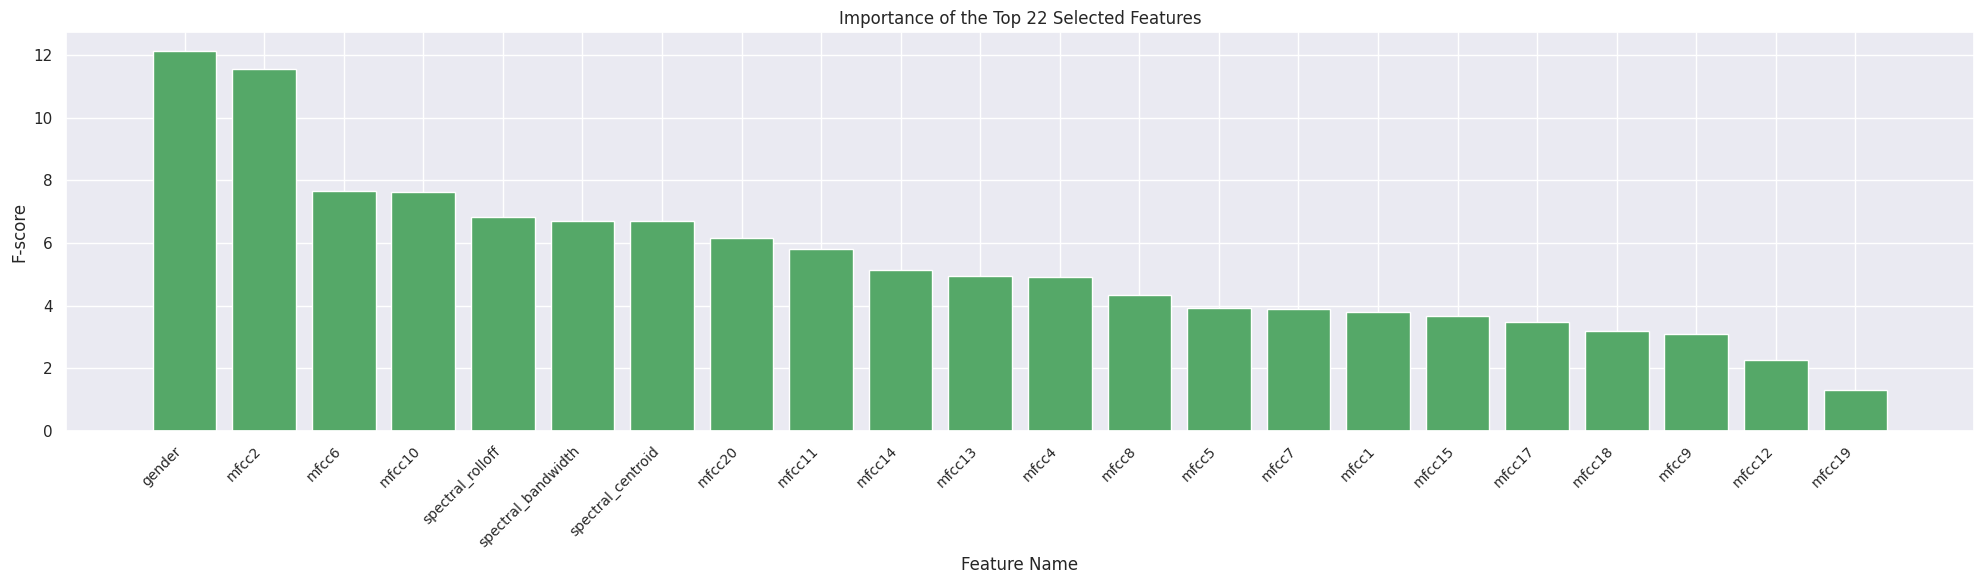


--- Step 4: Finding the Best Model with GridSearchCV ---

Evaluating Classifier: SVC
	Fold 1, Best Params {'C': 100, 'gamma': 'auto'}, F1 on Test: 0.469
	Fold 2, Best Params {'C': 100, 'gamma': 'scale'}, F1 on Test: 0.496
	Fold 3, Best Params {'C': 100, 'gamma': 'auto'}, F1 on Test: 0.486
	-> Average F1 Score for SVC: 0.484
	   -> New best model found! Refitting on all data.

Evaluating Classifier: RandomForestClassifier
	Fold 1, Best Params {'n_estimators': 150}, F1 on Test: 0.329
	Fold 2, Best Params {'n_estimators': 150}, F1 on Test: 0.251
	Fold 3, Best Params {'n_estimators': 100}, F1 on Test: 0.258
	-> Average F1 Score for RandomForestClassifier: 0.279

--- Step 5: Final Evaluation of the Best Model: SVC ---


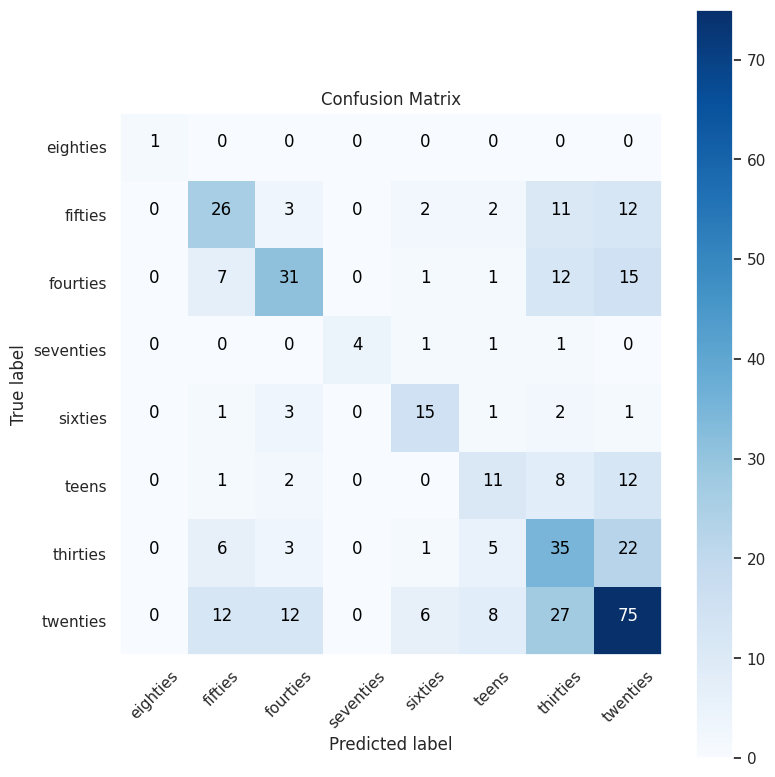

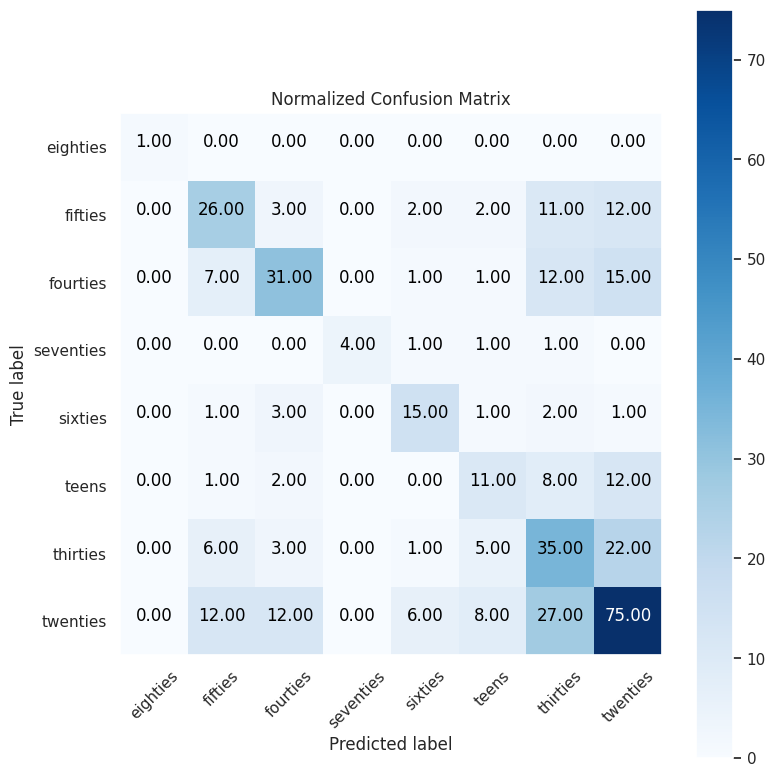


--- Step 6: Saving the Final Model ---
✅ Best model saved successfully to disk as 'finalized_age_voice_model.sav'


In [ ]:
# This cell assumes the 'df_features' DataFrame is ready from the previous step.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools
import joblib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

# --- Step 1: Scale Numerical Features ---
print("--- Step 1: Scaling Features ---")
def scale_features(data):
    features_to_scale = data.iloc[:, :-1]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np.array(features_to_scale, dtype=float))
    return scaled_data, scaler

x, scaler = scale_features(df_features)
print("Features scaled successfully.")

# --- THIS IS THE CORRECTED PART ---
# Use np.round() for robust rounding on arrays with mixed types
print(f"Original first sample's features: {np.round(df_features.iloc[0].values[:-1].astype(float), 2)}")
print(f"Scaled first sample's features:   {np.round(x[0], 2)}")
# --- END OF CORRECTION ---


# --- Step 2: Encode Categorical Labels ---
print("\n--- Step 2: Encoding Labels ---")
def get_labels(data):
    labels = data.iloc[:, -1]
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels, encoder

y, encoder = get_labels(df_features)
classes = encoder.classes_
print(f"Original first label: '{df_features.iloc[0].values[-1]}'")
print(f"Encoded first label:  {y[0]}")
print(f"All unique class labels: {classes}")


# --- Step 3: Select the Best Features ---
print("\n--- Step 3: Performing Feature Selection ---")
n_features = 22
f_selector = SelectKBest(f_classif, k=n_features).fit(x, y)
X_new = f_selector.transform(x)

scores = f_selector.scores_
indices = np.argsort(scores)[::-1]

print("Plotting the importance of the top features...")
selected_features = [df_features.columns[i] for i in indices[:n_features]]
plt.figure(figsize=(20, 6))
plt.bar(selected_features, scores[indices[:n_features]], color='g')
plt.title("Importance of the Top 22 Selected Features")
plt.xlabel("Feature Name")
plt.ylabel("F-score")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()


# --- Step 4: Find the Best Model using Nested Cross-Validation ---
# IMPORTANT: This step is computationally expensive and will take a long time to run.
print("\n--- Step 4: Finding the Best Model with GridSearchCV ---")
# (The rest of the code for GridSearchCV, Evaluation, and Saving is the same)
classifiers_and_params = [
    (SVC(random_state=0), {'C': [100, 150, 200], 'gamma': ['auto', 'scale']}),
    (RandomForestClassifier(random_state=0), {'n_estimators': [100, 150, 200]})
]

overall_best_model = None
overall_best_score = 0.0

for classifier, params in classifiers_and_params:
    print(f"\nEvaluating Classifier: {classifier.__class__.__name__}")
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)
    fold_results = []

    for fold_counter, (train_idx, test_idx) in enumerate(outer_cv.split(X_new), 1):
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        inner_cv = KFold(n_splits=2, shuffle=True, random_state=0)
        gs = GridSearchCV(classifier, params, scoring='f1_macro', cv=inner_cv, refit=True)
        res = gs.fit(X_train, y_train)

        best_model_in_fold = res.best_estimator_
        pred = best_model_in_fold.predict(X_test)
        score = f1_score(y_test, pred, average='macro')
        fold_results.append(score)

        print(f"\tFold {fold_counter}, Best Params {res.best_params_}, F1 on Test: {score:.3f}")

    avg_f1_score = np.mean(fold_results)
    print(f'\t-> Average F1 Score for {classifier.__class__.__name__}: {avg_f1_score:.3f}')

    if avg_f1_score > overall_best_score:
        overall_best_score = avg_f1_score
        print(f"\t   -> New best model found! Refitting on all data.")
        final_grid_search = GridSearchCV(classifier, params, scoring='f1_macro', cv=inner_cv, refit=True)
        final_grid_search.fit(X_new, y)
        overall_best_model = final_grid_search.best_estimator_

# --- Step 5: Evaluate the Overall Best Model ---
print(f"\n--- Step 5: Final Evaluation of the Best Model: {overall_best_model.__class__.__name__} ---")

def my_plot_confusion_matrix(cm, classes, normalize=False):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues); plt.colorbar()
    tick_marks = np.arange(len(classes)); plt.xticks(tick_marks, classes, rotation=45); plt.yticks(tick_marks, classes)
    title = "Normalized Confusion Matrix" if normalize else "Confusion Matrix"; plt.title(title)
    thresh = cm.max() / 2.; fmt = "{:0.2f}" if normalize else "{:d}"
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt.format(cm[i, j]), ha="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout(); plt.ylabel('True label'); plt.xlabel('Predicted label')

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_new, y, test_size=0.2, random_state=0)
overall_best_model.fit(X_train_final, y_train_final)
y_pred = overall_best_model.predict(X_test_final)

cm = confusion_matrix(y_test_final, y_pred)
plt.figure(figsize=(8, 8)); my_plot_confusion_matrix(cm, classes=classes)
plt.grid(False); plt.show()
plt.figure(figsize=(8, 8)); my_plot_confusion_matrix(cm, classes=classes, normalize=True)
plt.grid(False); plt.show()

# --- Step 6: Save the Final Model ---


In [ ]:
# --- Step 6: Save the Final Model AND Pipeline Components ---
print("\n--- Step 6: Saving the Final Model and Pipeline ---")

# Define the save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks'
os.makedirs(save_dir, exist_ok=True) # Create the directory if it doesn't exist

# Save the best model
joblib.dump(overall_best_model, os.path.join(save_dir, 'final_model.sav'))

# Save the feature scaler
joblib.dump(scaler, os.path.join(save_dir, 'scaler.sav'))

# Save the feature selector
joblib.dump(f_selector, os.path.join(save_dir, 'feature_selector.sav'))

# Save the label encoder
joblib.dump(encoder, os.path.join(save_dir, 'label_encoder.sav'))

print(f"✅ Best model and pipeline components saved successfully to {save_dir}!")


--- Step 6: Saving the Final Model and Pipeline ---
✅ Best model and pipeline components saved successfully to /content/drive/MyDrive/Colab Notebooks!


In [ ]:
import numpy as np
import pandas as pd
import librosa
import joblib
import os

# --- 1. Load All Our Saved Pipeline Components ---
print("--- Loading pipeline components ---")
model = joblib.load('final_model.sav')
scaler = joblib.load('scaler.sav')
feature_selector = joblib.load('feature_selector.sav')
encoder = joblib.load('label_encoder.sav')
print("✅ All components loaded successfully.")


# --- 2. Create a Feature Extraction Function for a SINGLE File ---
# This must be identical to the feature extraction used in training.
def extract_single_file_features(audio_path, sampling_rate=48000):
    try:
        features = list()
        audio, _ = librosa.load(audio_path, sr=sampling_rate, duration=5)

        # We don't have a gender label for a new file, so we'll use a placeholder (e.g., 0)
        # Note: The model will learn to ignore this if it's not an important feature.
        gender_placeholder = 0.0

        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))

        features.append(gender_placeholder)
        features.append(spectral_centroid)
        features.append(spectral_bandwidth)
        features.append(spectral_rolloff)

        mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
        for el in mfcc:
            features.append(np.mean(el))

        return np.array(features)
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None


# --- 3. The Main Prediction Function ---
def predict_age_from_audio(file_path):
    print(f"\n--- Predicting age for: {os.path.basename(file_path)} ---")

    # 1. Extract features from the new audio file
    raw_features = extract_single_file_features(file_path)
    if raw_features is None:
        return "Could not process audio file."

    # Reshape for the scaler (it expects a 2D array)
    raw_features_2d = raw_features.reshape(1, -1)

    # 2. Scale the features using the SAME scaler from training
    scaled_features = scaler.transform(raw_features_2d)

    # 3. Select the best features using the SAME selector from training
    final_features = feature_selector.transform(scaled_features)

    # 4. Make a prediction using the loaded model
    prediction_encoded = model.predict(final_features)

    # 5. Decode the prediction back to a human-readable label
    prediction_label = encoder.inverse_transform(prediction_encoded)

    return prediction_label[0]


# --- 4. Let's Try It Out! ---
# We'll grab a random file from the test set we created earlier to test our pipeline.
# In a real application, you would replace this with a path to any new audio file.
try:
    # This assumes 'X_test_final' and 'y_test_final' exist from the training script
    # Let's find the original path for a test sample
    test_index = 5 # Use the 5th file from the test set
    original_index_in_df = X_test_final.index[test_index]
    test_file_path = df_features.iloc[original_index_in_df].name

    # Reconstruct the correct path (this is a bit complex, let's simplify)
    # Let's just pick one of the paths we know is in our 'data' DataFrame.
    random_sample = data.sample(1).iloc[0]
    test_file_path = random_sample['full_path']
    true_label = random_sample['age']

    # Get the prediction
    predicted_age = predict_age_from_audio(test_file_path)

    print("\n--- RESULT ---")
    print(f"The true age group is:   {true_label}")
    print(f"The predicted age group is: {predicted_age}")

except NameError:
    print("\nCould not find a test file to predict. Please provide a path to an audio file.")
    # Example: predict_age_from_audio('/path/to/your/new_voice.mp3')

--- Loading pipeline components ---
✅ All components loaded successfully.

--- Predicting age for: sample-027230.mp3 ---

Could not find a test file to predict. Please provide a path to an audio file.


In [ ]:
import numpy as np
import pandas as pd
import librosa
import joblib
import os

# --- 1. Load All Our Saved Pipeline Components ---
print("--- Loading pipeline components ---")
# Define the directory where components were saved
save_dir = '/content/drive/MyDrive/Colab Notebooks'

try:
    model = joblib.load(os.path.join(save_dir, 'final_model.sav'))
    scaler = joblib.load(os.path.join(save_dir, 'scaler.sav'))
    feature_selector = joblib.load(os.path.join(save_dir, 'feature_selector.sav'))
    encoder = joblib.load(os.path.join(save_dir, 'label_encoder.sav'))
    print("✅ All components loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error loading pipeline components: {e}")
    print("Please ensure the files 'final_model.sav', 'scaler.sav', 'feature_selector.sav', and 'label_encoder.sav' exist in the specified save directory.")
    model, scaler, feature_selector, encoder = None, None, None, None # Set to None if loading fails


# --- 2. Create a Feature Extraction Function for a SINGLE File ---
def extract_single_file_features(audio_path, sampling_rate=48000):
    try:
        features = list()
        audio, _ = librosa.load(audio_path, sr=sampling_rate, duration=5)

        # Placeholder for gender (since unknown during prediction)
        gender_placeholder = 0.0

        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))

        features.append(gender_placeholder)
        features.append(spectral_centroid)
        features.append(spectral_bandwidth)
        features.append(spectral_rolloff)

        mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
        for el in mfcc:
            features.append(np.mean(el))

        return np.array(features)
    except Exception as e:
        print(f"❌ Error processing {audio_path}: {e}")
        return None


# --- 3. The Main Prediction Function ---
def predict_age_from_audio(file_path):
    if model is None or scaler is None or feature_selector is None or encoder is None:
        return "Error: Pipeline components not loaded correctly."

    print(f"\n--- Predicting age for: {os.path.basename(file_path)} ---")

    # 1. Extract features
    raw_features = extract_single_file_features(file_path)
    if raw_features is None:
        return "Could not process audio file."

    # Reshape for scaler (expects 2D array)
    raw_features_2d = raw_features.reshape(1, -1)

    # 2. Scale features
    scaled_features = scaler.transform(raw_features_2d) # Corrected this line

    # 3. Select best features
    final_features = feature_selector.transform(scaled_features)

    # 4. Predict
    prediction_encoded = model.predict(final_features)

    # 5. Decode to label
    prediction_label = encoder.inverse_transform(prediction_encoded)

    return prediction_label[0]


# --- 4. Example Usage ---
try:
    # Example: using a random file from your dataset if loaded
    # Check if 'data' DataFrame exists before trying to use it
    if 'data' in locals() or 'data' in globals():
        random_sample = data.sample(1).iloc[0] # Changed index to 0 for robustness
        test_file_path = random_sample['full_path']
        true_label = random_sample['age']

        predicted_age = predict_age_from_audio(test_file_path)

        print("\n--- RESULT ---")
        print(f"✅ True age group:   {true_label}")
        print(f"🎯 Predicted age group: {predicted_age}")
    else:
        print("\n⚠️ 'data' DataFrame not found. Please provide an audio file path manually.")
        # Example usage: Uncomment and replace with your file path
        # test_file_path_manual = '/content/drive/MyDrive/Colab Notebooks/sample_voice.wav'
        # predicted_age_manual = predict_age_from_audio(test_file_path_manual)
        # print("Predicted Age Group:", predicted_age_manual)

except NameError:
    print("\n⚠️ An unexpected error occurred. Please check the code and try again.")
    # Example usage: Uncomment and replace with your file path
    # test_file_path_manual = '/content/drive/MyDrive/Colab Notebooks/sample_voice.wav'
    # predicted_age_manual = predict_age_from_audio(test_file_path_manual)
    # print("Predicted Age Group:", predicted_age_manual)

--- Loading pipeline components ---
✅ All components loaded successfully.

--- Predicting age for: sample-104576.mp3 ---

--- RESULT ---
✅ True age group:   fifties
🎯 Predicted age group: thirties


In [ ]:
import numpy as np
import pandas as pd
import librosa
import joblib
import os
from IPython.display import Javascript, display
from google.colab import output
from base64 import b64decode
import scipy.io.wavfile as wav

# --- 1. Load All Our Saved Pipeline Components ---
# This assumes your saved files are in the main /content/ directory
print("--- Loading pipeline components ---")
try:
    model = joblib.load('final_model.sav')
    scaler = joblib.load('scaler.sav')
    feature_selector = joblib.load('feature_selector.sav')
    encoder = joblib.load('label_encoder.sav')
    print("✅ All components loaded successfully.")
except FileNotFoundError:
    print("❌ ERROR: Could not find saved model/pipeline files (.sav).")
    print("Please make sure you have run the training and saving script first.")


# --- 2. JavaScript code to handle audio recording in the browser ---
# This code runs locally in your browser, not on the Colab server.
RECORD_JS = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.target.result)
  reader.readAsDataURL(blob)
})

var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.onstop = async() => {
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.start()
  await sleep(time)
  recorder.stop()
  stream.getAudioTracks().forEach(track => track.stop());
})
"""

def record_audio(seconds=5):
  """
  Executes the JavaScript to record audio and returns the result.
  """
  display(Javascript(RECORD_JS))
  print(f"Recording for {seconds} seconds...")
  # Execute the JavaScript function 'record' and pass the duration
  s = output.eval_js(f'record({seconds * 1000})')
  print("Recording finished.")
  # The result 's' is a base64-encoded string, extract the data part
  b = b64decode(s.split(',')[1])
  # Define a temporary filename
  temp_filename = 'temp_audio.wav'
  # Write the decoded audio bytes to a WAV file
  # Note: The browser typically records at 48000 Hz sample rate
  wav.write(temp_filename, 48000, np.frombuffer(b, dtype=np.int16))
  return temp_filename


# --- 3. Feature Extraction and Prediction Functions ---
# These are the same functions from our previous script.

def extract_single_file_features(audio_path, sampling_rate=48000):
    try:
        features = list()
        audio, _ = librosa.load(audio_path, sr=sampling_rate, duration=5)
        gender_placeholder = 0.0

        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))

        features.extend([gender_placeholder, spectral_centroid, spectral_bandwidth, spectral_rolloff])

        mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
        for el in mfcc:
            features.append(np.mean(el))

        return np.array(features)
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def predict_age_from_audio(file_path):
    raw_features = extract_single_file_features(file_path)
    if raw_features is None: return "Could not process audio file."

    raw_features_2d = raw_features.reshape(1, -1)
    scaled_features = scaler.transform(raw_features_2d)
    final_features = feature_selector.transform(scaled_features)
    prediction_encoded = model.predict(final_features)
    prediction_label = encoder.inverse_transform(prediction_encoded)

    return prediction_label[0]


# --- 4. The Main Event: Record and Predict! ---
print("\n--- GET READY TO RECORD ---")
# Call the function to start the recording process
recorded_file = record_audio(5)

# Pass the filename of our new recording to the prediction function
predicted_age = predict_age_from_audio(recorded_file)

print("\n--- PREDICTION RESULT ---")
print(f"The model predicts the speaker's age group is: '{predicted_age}'")

--- Loading pipeline components ---
✅ All components loaded successfully.

--- GET READY TO RECORD ---


<IPython.core.display.Javascript object>

Recording for 5 seconds...
Recording finished.

--- PREDICTION RESULT ---
The model predicts the speaker's age group is: 'twenties'


In [ ]:
test_file_path = "/content/drive/MyDrive/Colab Notebooks/sample-audio.opus"
predicted_age = predict_age_from_audio(test_file_path)
print("Predicted Age Group:", predicted_age)



--- Predicting age for: sample-audio.opus ---
Predicted Age Group: fourties


--- Let's look at the distribution of age groups in your final dataset ---
age
twenties     23390
thirties     18675
fourties     11147
fifties       9647
teens         5558
sixties       4672
seventies     1668
eighties       244
Name: count, dtype: int64


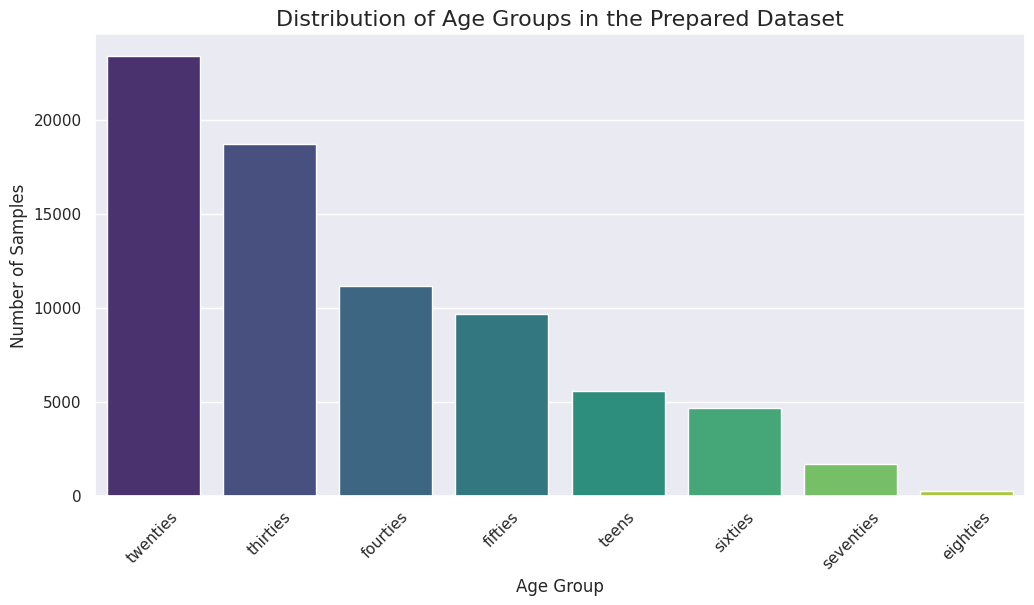

In [ ]:
# This assumes 'data' is your final, cleaned DataFrame before feature extraction.

print("--- Let's look at the distribution of age groups in your final dataset ---")

# Get the counts for each age group
age_counts = data['age'].value_counts()
print(age_counts)

# Plot it to visualize the imbalance
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(x=age_counts.index, y=age_counts.values, palette="viridis")
plt.title('Distribution of Age Groups in the Prepared Dataset', fontsize=16)
plt.ylabel('Number of Samples', fontsize=12)
plt.xlabel('Age Group', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# --- Step 1: INSTALLATIONS AND IMPORTS ---
!pip install librosa joblib scikit-learn -q

import numpy as np
import pandas as pd
import librosa
import joblib
from google.colab import files, output, drive
from IPython.display import Audio, Javascript, display
import os
from base64 import b64decode
import scipy.io.wavfile as wav

print("✅ Libraries imported.")


# --- Step 2: DEFINE THE CORRECTED PREDICTOR CLASS ---

class ColabAudioPredictor:
    # --- FIXED: Correct constructor name __init__ ---
    def __init__(self, model_dir='/content/'):
        """
        Initializes the predictor by loading all pipeline components.
        """
        print("--- Loading pipeline components ---")
        try:
            self.model = joblib.load(os.path.join(model_dir, 'final_model.sav'))
            self.scaler = joblib.load(os.path.join(model_dir, 'scaler.sav'))
            self.feature_selector = joblib.load(os.path.join(model_dir, 'feature_selector.sav'))
            self.label_encoder = joblib.load(os.path.join(model_dir, 'label_encoder.sav'))
            print("✅ All components loaded successfully.")
            self.is_loaded = True
        except FileNotFoundError as e:
            print(f"❌ ERROR: Could not find a model file. {e}")
            print("Please make sure your .sav files are in the specified directory.")
            self.is_loaded = False

    # --- FIXED: Use the CORRECT feature extraction function from training ---
    def extract_features(self, audio_path):
        """
        Extracts the exact same features the model was trained on.
        """
        try:
            features = list()
            audio, _ = librosa.load(audio_path, sr=48000, duration=5)

            # We use a placeholder for gender since it's unknown for a new file.
            gender_placeholder = 0.0

            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=48000))
            spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=48000))
            spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=48000))

            features.extend([gender_placeholder, spectral_centroid, spectral_bandwidth, spectral_rolloff])

            mfcc = librosa.feature.mfcc(y=audio, sr=48000)
            for el in mfcc:
                features.append(np.mean(el))

            return np.array(features).reshape(1, -1)
        except Exception as e:
            print(f"Error during feature extraction: {e}")
            return None

    def predict_age(self, audio_path):
        """
        Runs the full prediction pipeline on a single audio file.
        """
        if not self.is_loaded:
            return "Error: Models are not loaded."

        try:
            # 1. Extract features
            features = self.extract_features(audio_path)
            if features is None: return "Feature extraction failed."

            # 2. Scale features
            features_scaled = self.scaler.transform(features)

            # 3. Select best features
            features_selected = self.feature_selector.transform(features_scaled)

            # 4. Predict
            prediction = self.model.predict(features_selected)

            # 5. Decode the label
            age_group = self.label_encoder.inverse_transform(prediction)[0]
            return age_group
        except Exception as e:
            return f"Error during prediction: {str(e)}"

    def upload_and_predict(self):
        """
        Handles the file upload process in Colab.
        """
        print("\nPlease upload your audio file (e.g., .wav, .mp3, .opus):")
        uploaded = files.upload()

        for filename in uploaded.keys():
            print(f"\n--- Processing: {filename} ---")

            # The uploaded file is already saved, so we can use its name directly
            age_group = self.predict_age(filename)
            print(f"🎯 Predicted Age Group: '{age_group}'")

            display(Audio(filename))
            os.remove(filename) # Clean up the temporary file

    # --- FIXED: Corrected the JavaScript execution and audio handling ---
    def record_and_predict(self, seconds=5):
        """
        Handles real-time audio recording in Colab.
        """
        RECORD_JS = """
        const sleep = time => new Promise(resolve => setTimeout(resolve, time))
        const b2text = blob => new Promise(resolve => {
          const reader = new FileReader()
          reader.onloadend = e => resolve(e.target.result)
          reader.readAsDataURL(blob)
        })
        var record = time => new Promise(async resolve => {
          stream = await navigator.mediaDevices.getUserMedia({ audio: true })
          recorder = new MediaRecorder(stream)
          chunks = []
          recorder.ondataavailable = e => chunks.push(e.data)
          recorder.onstop = async() => {
            blob = new Blob(chunks)
            text = await b2text(blob)
            resolve(text)
          }
          recorder.start()
          await sleep(time)
          recorder.stop()
          stream.getAudioTracks().forEach(track => track.stop());
        })
        """

        try:
            display(Javascript(RECORD_JS))
            print(f"🎙️ Get Ready! Recording for {seconds} seconds...")
            s = output.eval_js(f'record({seconds * 1000})')
            print("Recording finished.")

            # Decode and save the audio
            b = b64decode(s.split(',')[1])
            temp_filename = 'live_recording.wav'
            wav.write(temp_filename, 48000, np.frombuffer(b, dtype=np.int16))

            # Predict on the new recording
            age_group = self.predict_age(temp_filename)
            print(f"🎯 Predicted Age Group: '{age_group}'")

            display(Audio(temp_filename))
            os.remove(temp_filename)
        except Exception as e:
            print(f"Could not record audio. Make sure you are in a browser environment like Chrome and have granted microphone permissions. Error: {e}")

# --- Step 3: CHOOSE HOW TO GET THE MODELS ---

# OPTION A: Mount Google Drive (Recommended)
print("--- Mounting Google Drive to load models ---")
drive.mount('/content/drive')
model_directory = '/content/drive/MyDrive/Colab Notebooks' # The folder where you saved the models

# OPTION B: Upload files manually each time
# print("Please upload your 4 .sav model files (final_model, scaler, feature_selector, label_encoder)...")
# files.upload()
# model_directory = '/content/' # Files will be in the root directory

# --- Step 4: RUN THE PREDICTOR ---
predictor = ColabAudioPredictor(model_dir=model_directory)

if predictor.is_loaded:
    print("\nChoose an option:")
    print("1. Upload an audio file")
    print("2. Record live audio from microphone")
    choice = input("Enter choice (1 or 2): ")

    if choice == '1':
        predictor.upload_and_predict()
    elif choice == '2':
        predictor.record_and_predict()
    else:
        print("Invalid choice.")

✅ Libraries imported.
--- Mounting Google Drive to load models ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Loading pipeline components ---
✅ All components loaded successfully.

Choose an option:
1. Upload an audio file
2. Record live audio from microphone
Enter choice (1 or 2): 1

Please upload your audio file (e.g., .wav, .mp3, .opus):


Saving sample-audio2.opus to sample-audio2.opus

--- Processing: sample-audio2.opus ---
🎯 Predicted Age Group: 'thirties'
